In [1]:
# ライブラリインポート

## 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 分解
import scipy.stats
from sklearn.model_selection import train_test_split
import my_function

## 学習
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

In [2]:
# データ読み込み

## csv読み込み
df = pd.read_csv('./available_csv/AirPassengers.csv')
print(df.head())

## データ整形（必要であれば）
df = df['Passengers']
print(df.head())

        Month  Passengers
0  1949-01-01         112
1  1949-02-01         118
2  1949-03-01         132
3  1949-04-01         129
4  1949-05-01         121
0    112
1    118
2    132
3    129
4    121
Name: Passengers, dtype: int64


In [3]:
# 分解（singleの場合、整形のみ）

## 正規化
raw_array = scipy.stats.zscore(df)

## データの整形
### default : SlideingWindow = 5
raw_x, raw_y = my_function.sliding_window(raw_array)

## データの分割
raw_x_train, raw_x_test, raw_y_train, raw_y_test = train_test_split(raw_x, raw_y, test_size=0.1, shuffle=False)

In [4]:
# 学習

## 単体学習
### RNN

#### モデル構築準備
length_of_sequence = raw_x_train.shape[1] 
in_out_neurons = 1
n_hidden = 300

#### モデル構築
model = Sequential()
model.add(LSTM(n_hidden, 
               batch_input_shape=(None, length_of_sequence, in_out_neurons), 
               return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam()
model.compile(loss="mean_squared_error", optimizer=optimizer)

## 処理前の時刻
t1 = time.time() 

#### 学習
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(raw_x_train, raw_y_train,
          batch_size=300,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stopping]
          )

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6687 - val_loss: 1.4507
Epoch 2/100
1/1 [==============================] - 0s 52ms/step - loss: 0.5470 - val_loss: 1.2867
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 0.4420 - val_loss: 1.1402
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 0.3530 - val_loss: 1.0109
Epoch 5/100
1/1 [==============================] - 0s 48ms/step - loss: 0.2808 - val_loss: 0.8982
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 0.2285 - val_loss: 0.8012
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 0.1998 - val_loss: 0.7195
Epoch 8/100
1/1 [==============================] - 0s 68ms/step - loss: 0.1960 - val_loss: 0.6567
Epoch 9/100
1/1 [==============================] - 0s 44ms/step - loss: 0.2087 - val_loss: 0.6150
Epoch 10/100
1/1 [==============================] - 0s 43ms/step - loss: 0.2185 - val_loss: 0.5890
Epoch 11/100
1/1 [===

In [5]:
# 予測

## 単体予測
lstm_pred = model.predict(raw_x_test)

## 処理後の時刻
t2 = time.time()

時間：7.140119552612305
MSE：0.9711236927565297
RMSE：0.9854560836265255
KLD：7.134170833871825


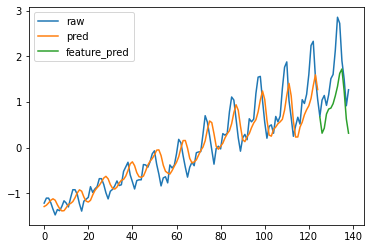

In [6]:
# 評価

## 学習時間
print(f"時間：{t2-t1}")

## 予測精度
print(f"MSE：{my_function.calc_mse(lstm_pred, raw_y_test)}")
print(f"RMSE：{my_function.calc_rmse(lstm_pred, raw_y_test)}")
print(f"KLD：{my_function.calc_kld(lstm_pred, raw_y_test)}")

## lstm
plt.figure()
plt.plot(raw_y, label='raw')
plt.plot(model.predict(raw_x_train).reshape(-1, 1), label='pred')
plt.plot(range((len(raw_y)-len(lstm_pred)),len(raw_y)),lstm_pred, label='feature_pred')
plt.legend()
plt.show()